# **Finding Lane Lines on the Road** 
***

Lane finding is crucial for developing algorithms for autonomous driving robots or self-driving cars.

In this project, I will use the tools I learned about in the lesson to identify lane lines on the road in an advance way.  I will develop pipelines on a series of individual images, and later apply the result to a video stream (really just a series of images). 



In [253]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle 
import os
import math

%matplotlib inline

#### chessboard distortion correction illustration

In [254]:
chessboard = mpimg.imread('camera_cal/calibration_example.jpg')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints =[] # 2D points in image space

objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y corrdinates

# Convert image to grayscale
gray = cv2.cvtColor(chessboard,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(chessboard, mtx, dist, None, mtx)    

In [255]:
imgpoints[0].shape

(48, 1, 2)

In [256]:
objpoints[0].shape

(48, 3)

In [257]:
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]


In [258]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

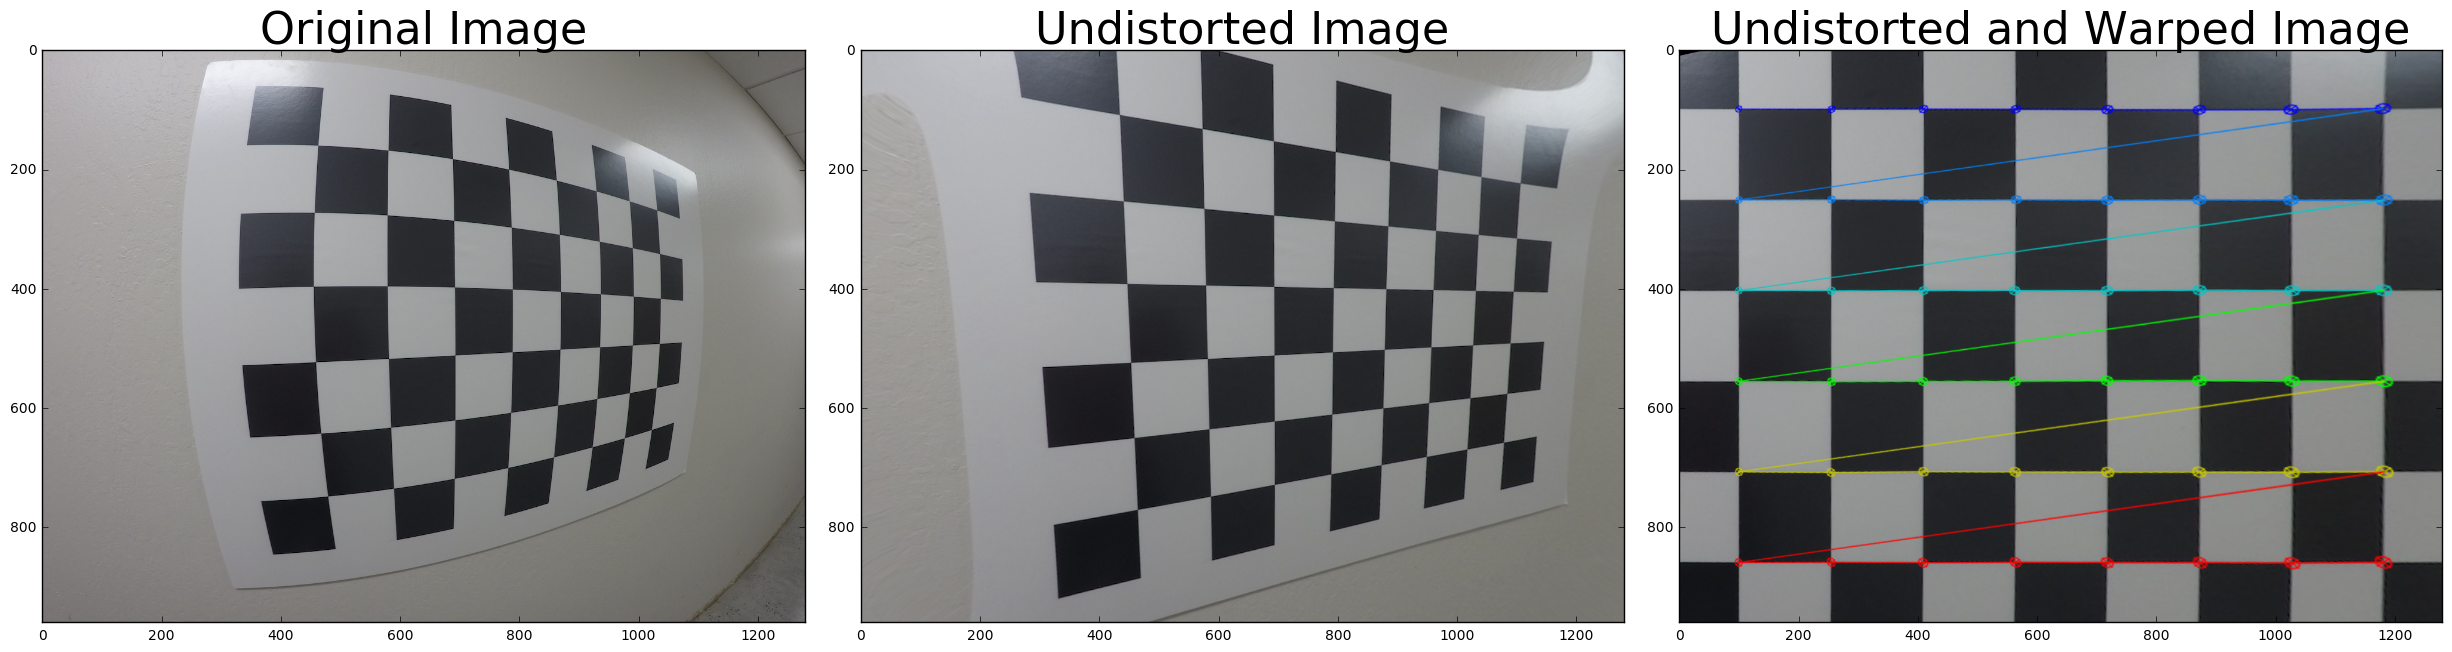

In [259]:
top_down, perspective_M = corners_unwarp(chessboard, nx, ny, mtx, dist)
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboard)
ax1.set_title('Original Image', fontsize=32)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=32)
ax3.imshow(top_down)
ax3.set_title('Undistorted and Warped Image', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 1. Image Processing: Thresholding

In [260]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
img_size = image.shape
mtx = data[0]
dist = data[1]

#printing out some stats and plotting
# print('This image is:', type(image), 'with dimesions:', image.shape)
# plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [296]:
### Helper functions


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


# apply a mask on the region of interest
def region_of_interest(img,vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    height = img.shape[0]
    width = img.shape[1]
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    if lines is not None:
        extendLines = []
        #extend line to the bottom
        for line in lines:
            for x1,y1,x2,y2 in line:
                k = float(y2-y1)/float(x2-x1)
                if y1 > y2 and 0<x2 + float(height-y2)/k<width:
                    x1 = int(x2 + float(height-y2)/k)
                    y1 = height
                elif y1 < y2 and 0<x1 + float(height-y1)/k<width:
                    x2 = int(x1 + float(height-y1)/k)
                    y2 = height
                else:
                    pass
                extendLines.append([[x1, y1, x2, y2]])
        draw_lines(line_img, extendLines, thickness=12)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Apply a perspective transform to rectify binary image ("birds-eye view").
def perspective_trans(img, mtx, dist):
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    img_x = img.shape[1]
    img_y = img.shape[0]

#     area_of_interest = np.array([[(0.14*img_x,img_y),(0.443*img_x, 0.63*img_y),
#                           (0.56*img_x, 0.63*img_y), (0.9*img_x,img_y)]], dtype=np.int32)
    area_of_interest = np.array([[(0.145*img_x,img_y),(0.457*img_x, 0.63*img_y),
                          (0.542*img_x, 0.63*img_y), (0.875*img_x,img_y)]], dtype=np.int32)

    offset = 200
    offset2 = 10
    offset3 = 565

    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[0+offset, img_x-offset3], [0+offset, 0+offset2], 
                       [img_y+offset,0+offset2], [img_y+offset,img_x-offset3]])    
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M,Minv
# Edit this function to create your own pipeline.


def pipeline_old(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
#     img = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return s_binary, color_binary

In [262]:
# add_thresholds and return a binary image


# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# def add_thresholds(img):
    
#     #  gradient threshold on the grayscale image
#     gray = grayscale(img) # convert to gray scale
#     # gradient direction thredhold
#     dir_g = dir_threshold(gray, sobel_kernel=15, dir_thresh = (0.7, 1.3))
#     # gradient magnitude thredhold
#     mag_g = mag_thresh(gray, sobel_kernel=9, mag_thresh = (30, 150))

    
#     # gradient threshold on the S channel
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     s_channel = hls[:,:,2] # select the s cannel
#     # gradient direction thredhold
#     dir_s = dir_threshold(s_channel, sobel_kernel=15, dir_thresh = (0.7, 1.3))
#     # gradient magnitude thredhold
#     mag_s = mag_thresh(s_channel, sobel_kernel=9, mag_thresh = (30, 150))


#     # combine thredholds
#     combined_binary = np.zeros_like(mag_g)
#     combined_binary[(((mag_g == 1) & (dir_g == 1)) | ((mag_s == 1) & (dir_s == 1)))] = 1
#     return combined_binary

def pipeline(img,vertice = False):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1050, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
#     vertices = np.array([[left_bottom, apex1, apex2, \
#                           right_bottom, inner_right_bottom, \
#                           inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    vertices = np.array([[left_bottom, apex1, apex2, \
                              right_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    if vertice:
        return color_binary,vertices 
    else:
        return color_binary

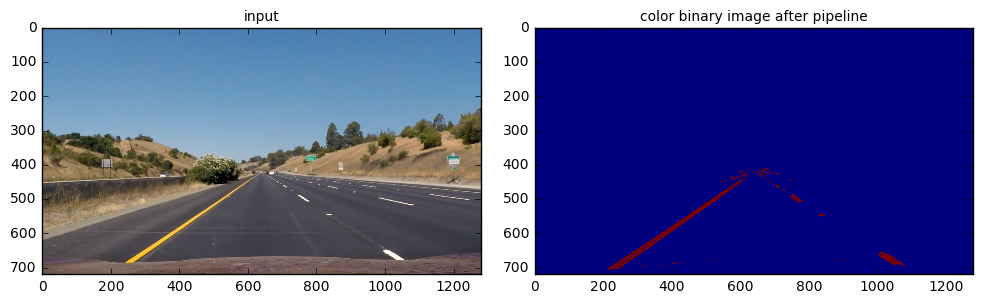

In [297]:
# Test if the region of interest correctly implemented
# image = img1
undist = cv2.undistort(image, mtx, dist, None, mtx)
color_binary,vertices =pipeline(undist,True)

# visualize
f, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('input', fontsize=10)
ax2.imshow(color_binary)
ax2.set_title('color binary image after pipeline', fontsize=10)

In [299]:
top_down, M,Minv = perspective_trans(color_binary, mtx, dist)
# plt.imshow(top_down)
# plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
color_mask = pipeline_old(image)[1]


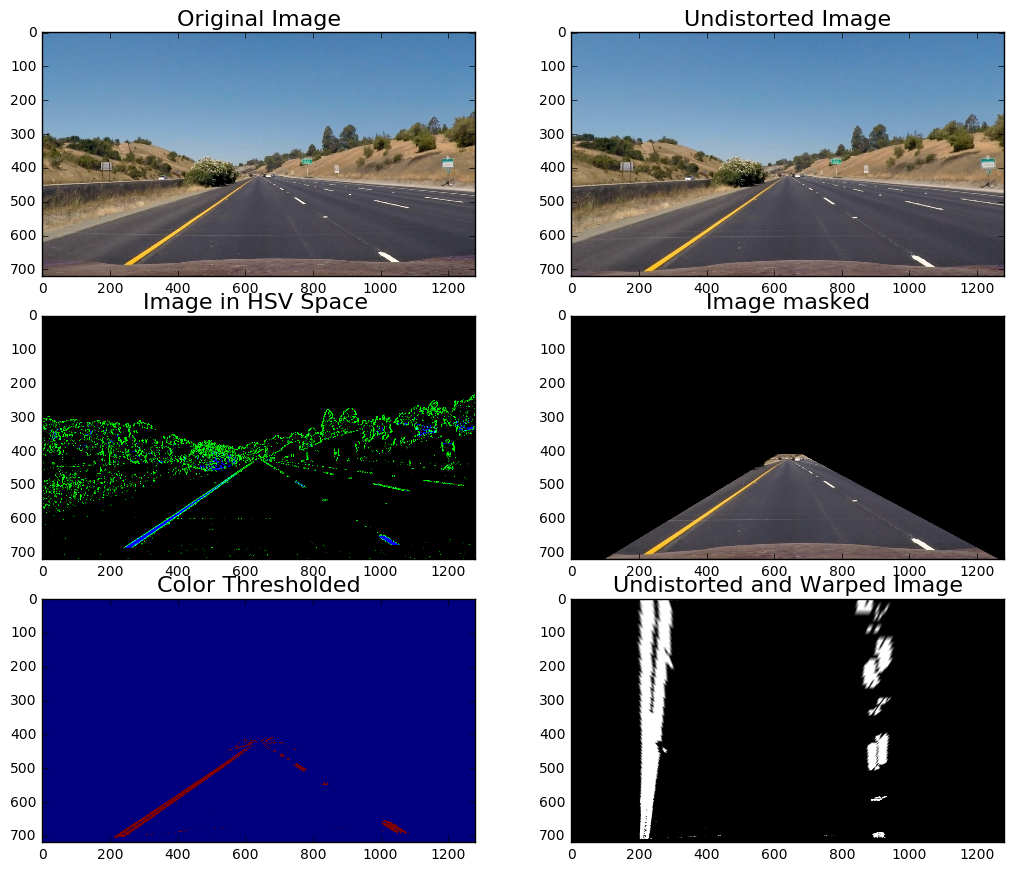

In [302]:
f, ((ax1, ax2),(ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(cv2.undistort(image, mtx, dist, None, mtx))
ax2.set_title('Undistorted Image', fontsize=16)
ax3.imshow(color_mask)
ax3.set_title('Image in HSV Space ', fontsize=16)
ax4.imshow(img_masked)
ax4.set_title('Image masked', fontsize=16)

ax5.imshow(color_binary)
ax5.set_title('Color Thresholded', fontsize=16)

# ax5.imshow(binary_masked, cmap='gray')
# ax5.set_title('Binary image masked', fontsize=16)
ax6.imshow(top_down,cmap='gray')
ax6.set_title('Undistorted and Warped Image', fontsize=16)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/color_threshold.jpg")

### 2. Finding the Lane

In [267]:
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
histogram = np.sum(top_down[top_down.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.savefig("output_images/hist.jpg")

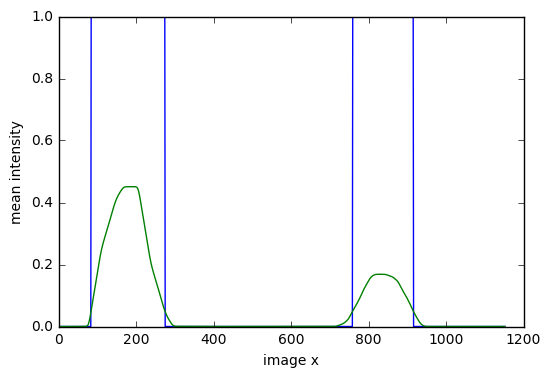

In [269]:
mov_filtsize = img_size[1]/10.
mean_lane = np.mean(top_down,axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')

In [270]:
def bird_eye_view(img,M):
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped

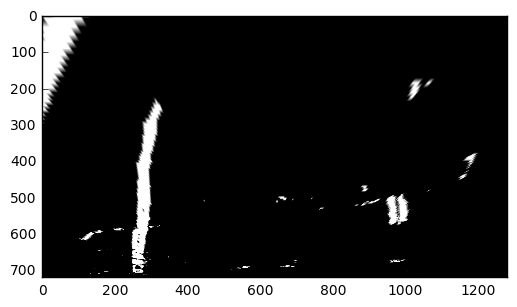

In [271]:
## load curvy road
# undistorted
img4 = mpimg.imread('test_images/test4.jpg')
img_undist = cv2.undistort(img4, mtx, dist, None, mtx)

# threshold
img_binary = pipeline(img_undist)

# # add mask
# img_x = img_binary.shape[1]
# img_y = img_binary.shape[0]
# vertices = np.array([[(0.05*img_x,img_y),(0.4*img_x, 0.63*img_y),
#                      (0.6*img_x, 0.63*img_y), (0.95*img_x,img_y)]], dtype=np.int32)
# img_masked = region_of_interest(img_binary,vertices)

# perspective transfer
top_down_color = bird_eye_view(img_masked, M) # color image
top_down_binary = bird_eye_view(img_binary, M) # binary image

# plot the bird eye view binary

plt.imshow(top_down_binary, cmap='gray')

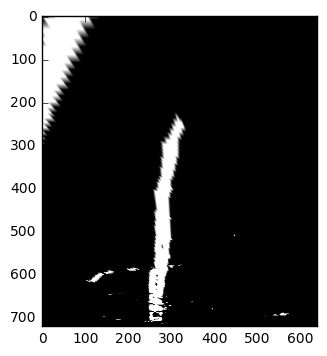

In [272]:
# split into left, right half
img = top_down_binary

mid = int(img.shape[1]/2)
img_left = img[:,0:mid-1]
img_right = img[:,mid:1280]


plt.imshow(img_left,cmap='gray')

In [273]:
def find_center(img):
    # find_starting_point
    # get haff of the image
    img_half = img[int(img.shape[0]/2):,:]
    img_blur = gaussian_blur(img_half, 9) # blur it

    histogram = np.sum(img_half, axis=0)

    center = np.argmax(histogram[0:mid])
    val = np.max(histogram[0:mid])
    return center,val

In [274]:
# test
center_left, val_left = find_center(img_left)
center_right, val_right = find_center(img_right)

print(center_left,center_right)

275 322


In [275]:
# find line pixels
def lane_points(img,center):
    # incialize empty
    # define small window
    window_wid = 180
    window_height = 60

    img_height = img.shape[0]
    x_vals =[]
    y_vals =[]
    lane_pixels = np.zeros_like(img)

    for n in range(12):
        #print(n)
        window = img[int(img_height-window_height):img_height,int(center-window_wid/2):int(center+window_wid/2)]
        hist2 = np.sum(window, axis=0)       
        max_hist = np.max(hist2)
        
        if max_hist > 5:
            new_center = np.argmax(hist2)+center-window_wid/2

            lane_pixels[int(img_height-window_height):img_height,\
                        int(center-window_wid/2):int(center+window_wid/2)] = window

            x_vals.append(new_center)
            #y_vals.append(img_height)
            y_vals.append(img_height - window_height/2)

            # update the center
            center = new_center
        img_height = img_height - window_height
    return x_vals,y_vals




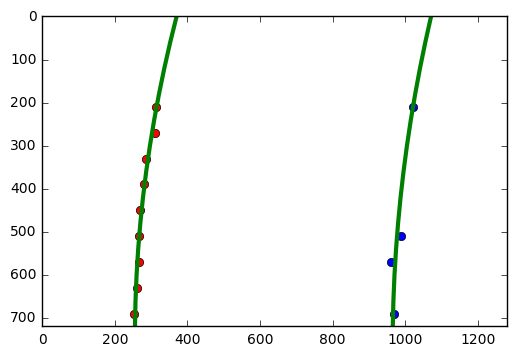

In [294]:

# Test
x_left,y_left = lane_points(img_left,center_left)
x_right,y_right = lane_points(img_right,center_right)

# off set 
x_right = [x+640 for x in x_right]


# fit left 
fit_left = np.polyfit(y_left, x_left, 2)
# fit right
fit_right = np.polyfit(y_right, x_right, 2) 

yvals = np.zeros(13)
fit_leftx = np.zeros(13)
fit_rightx = np.zeros(13)

for i in range(13):    
    yvals[i] = int(60*i)
    fit_leftx[i] = fit_left[0]*yvals[i]**2 + fit_left[1]*yvals[i] + fit_left[2]
    fit_rightx[i] = fit_right[0]*yvals[i]**2 + fit_right[1]*yvals[i] + fit_right[2]


#x_right = x_right + 640
plt.plot(x_left, y_left, 'o', color='red')
plt.plot(x_right, y_right, 'o', color='blue')
plt.plot(fit_rightx, yvals, color='green', linewidth=3)
plt.plot(fit_leftx, yvals, color='green', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.savefig("output_images/line_fitting.jpg")

In [277]:
def cast_back_lane(img,Minv,fit_left,fit_right,info_str ="info"):
    
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    yvals = np.zeros(13)
    fitx_left = np.zeros(13)
    fitx_right = np.zeros(13)

    for i in range(13):    
        yvals[i] = int(60*i)
        fitx_left[i] = fit_left[0]*yvals[i]**2 + fit_left[1]*yvals[i] + fit_left[2]
        fitx_right[i] = fit_right[0]*yvals[i]**2 + fit_right[1]*yvals[i] + fit_right[2]

        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fitx_left, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx_right, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    img_combined = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(img_combined, info_str, (30, 60), cv2.FONT_HERSHEY_COMPLEX, 1, (255,0,0), 2)

    return img_combined

In [278]:
# ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

In [279]:
# caculate lane curvature
def get_curvature(fit_model):
    y_eval = 720 # the maxium value on the y axis
    ym_per_pix = 30/720. 
    curverad = ((1 + (2*fit_model[0]*y_eval*ym_per_pix + fit_model[1])**2)**1.5) \
                             /np.absolute(2*fit_model[0])
    return curverad

In [280]:
x_left,x_right,y_left,y_right = np.array(x_left),np.array(x_right),np.array(y_left),np.array(y_right)
left_fit_cr = np.polyfit(y_left*ym_per_pix, x_left*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_right*ym_per_pix, x_right*xm_per_pix, 2)
left_curverad = get_curvature(left_fit_cr)
right_curverad = get_curvature(right_fit_cr)
real_time_curverad = "Left Curvature:{:8.2f} m,  Right Curvature:{:8.2f} m".format(left_curverad,right_curverad)
print(real_time_curverad)

Left Curvature:  806.92 m,  Right Curvature:  922.33 m


### 3. Building Pipeline

In [281]:
# may use Line class in the future
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [None,None,None]  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [282]:


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def find_center(img):
    # find_starting_point
    # get haff of the image
    img_half = img[int(img.shape[0]/2):,:]
    img_blur = gaussian_blur(img_half, 9) # blur it

    histogram = np.sum(img_half, axis=0)

    center = np.argmax(histogram[0:mid])
    val = np.max(histogram[0:mid])
    return center,val

def lane_points(img,center):
    # incialize empty
    # define small window
    window_wid = 180
    window_height = 60

    img_height = img.shape[0]
    x_vals =[]
    y_vals =[]
    lane_pixels = np.zeros_like(img)

    for n in range(12):
        #print(n)
        window = img[int(img_height-window_height):img_height,int(center-window_wid/2):int(center+window_wid/2)]
        hist2 = np.sum(window, axis=0)       
        max_hist = np.max(hist2)
        
        if max_hist > 5:
            new_center = np.argmax(hist2)+center-window_wid/2

            lane_pixels[int(img_height-window_height):img_height,\
                        int(center-window_wid/2):int(center+window_wid/2)] = window

            x_vals.append(new_center)
            #y_vals.append(img_height)
            y_vals.append(img_height - window_height/2)

            # update the center
            center = new_center
        img_height = img_height - window_height
    return x_vals,y_vals


def get_curvature(fit_model):
    y_eval = 720 # the maxium value on the y axis
    ym_per_pix = 30/720. 
    curverad = ((1 + (2*fit_model[0]*y_eval*ym_per_pix + fit_model[1])**2)**1.5) \
                             /np.absolute(2*fit_model[0])
    return curverad


# Caculate vehicle position
def get_position(center_left,center_right):
    position = 640
    lane_center = (center_left + center_right + 640)/2
    # Define conversions in x and y from pixels space to meters
    pix2meter = 3.7/661 # meteres per pixel in x dimension    
    pst = (position - lane_center)*pix2meter 
    return pst



def process_image(img,moving_avg = 0.):
     
    # undistort
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    # binary threshold
    #combined_binary = pipeline(img_undist)[0]
    combined_binary = pipeline(img_undist)

    
    top_down = bird_eye_view(combined_binary, M)
    
#     plt.imshow(top_down)
#     plt.show()
    # seperate left and right image
    mid = int(top_down.shape[1]/2)
    img_left = top_down[:,0:mid-1]
    img_right = top_down[:,mid:1280]
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension


    try:
        try:
            # find left lanes   
            center_left, val_left = find_center(img_left) # find center
            x_left,y_left = lane_points(img_left,center_left)
            fit_left = np.polyfit(y_left, x_left, 2)
            curve_fit_left = np.polyfit(np.array(y_left)*ym_per_pix, np.array(x_left)*xm_per_pix, 2)
           
            left_lane.detected = True
            left_lane.current_fit = fit_left
            if left_lane.best_fit[0] is None:
                left_lane.best_fit = fit_left
            else:
                left_lane.best_fit = moving_avg*left_lane.best_fit + (1-moving_avg)*fit_left
            left_lane.radius_of_curvature = get_curvature(curve_fit_left)
            left_lane.line_base_pos = center_left
  
        except:
#             print("left lane not found")
            left_lane.detected = False
            
            
        try:    
            # find right lanes
            center_right, val_right = find_center(img_right)   
            x_right,y_right = lane_points(img_right,center_right)
            x_right = [x+640 for x in x_right]  # off set 
            fit_right = np.polyfit(y_right, x_right, 2)
            curve_fit_right = np.polyfit(np.array(y_right,np.float32)*ym_per_pix, np.array(x_right,np.float32)*xm_per_pix, 2)
            right_lane.detected = True
            right_lane.current_fit = fit_right
            if right_lane.best_fit[0] is None:
                right_lane.best_fit = fit_right
            else:
                right_lane.best_fit = moving_avg*right_lane.best_fit + (1-moving_avg)*fit_right           
            right_lane.radius_of_curvature = get_curvature(curve_fit_right)
            right_lane.line_base_pos = center_right
            
        except:
#             print("right lane not found")
            right_lane.detected = False
            

        # wrap back
        #img_lane = cast_back_lane(img_undist,Minv,fit_left,fit_right)
        
#         x_left,x_right,y_left,y_right = np.array(x_left),np.array(x_right),np.array(y_left),np.array(y_right)
#         left_fit_cr = np.polyfit(y_left*ym_per_pix, x_left*xm_per_pix, 2)
#         right_fit_cr = np.polyfit(y_right*ym_per_pix, x_right*xm_per_pix, 2)
        
        # Now our radius of curvature is in meters
        # lane curvature
        lane_curvature = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2.

#         # car postion 
        car_position = get_position(left_lane.line_base_pos,right_lane.line_base_pos)
        real_time_curverad = "Distance to Center:{:8.2f} m,  Lane Curvature:{:8.2f} m".format(car_position,lane_curvature)
        img_lane = cast_back_lane(img_undist,Minv,left_lane.best_fit,right_lane.best_fit,real_time_curverad)
    except:
        print("not cast back")
        img_lane = img_undist
    
#     return None
    return img_lane

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

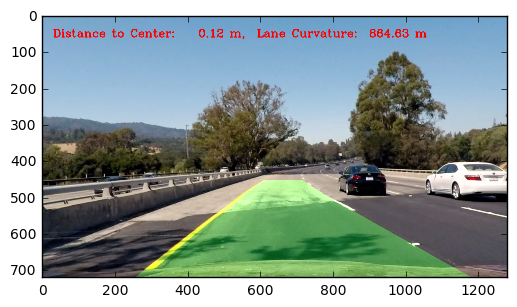

In [293]:
left_lane = Line() 
right_lane = Line()
out_image = process_image(img4)
plt.imshow(out_image)
plt.savefig("output_images/pipeline_out.jpg")

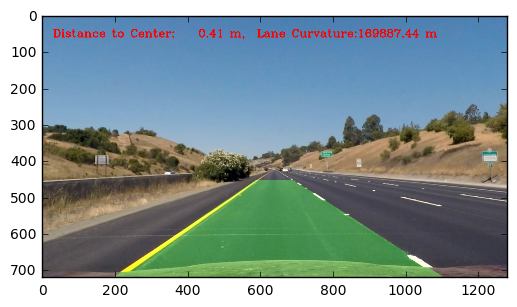

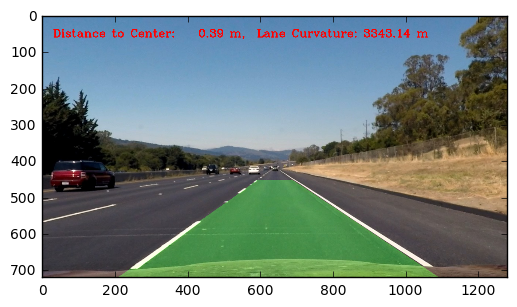

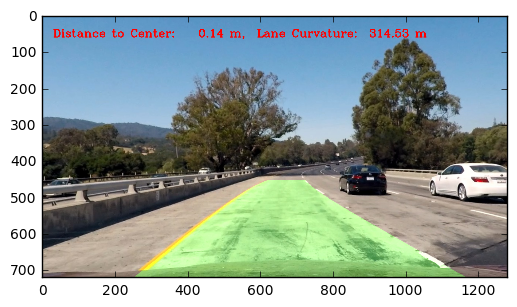

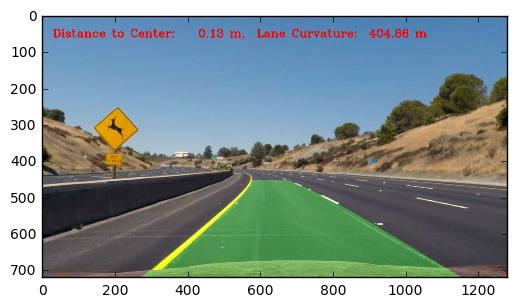

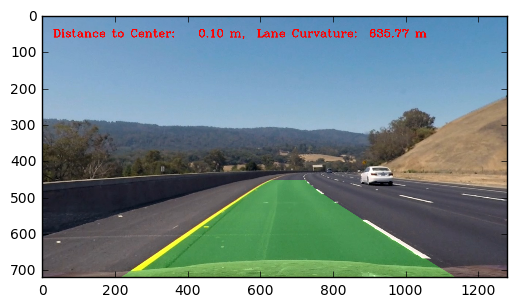

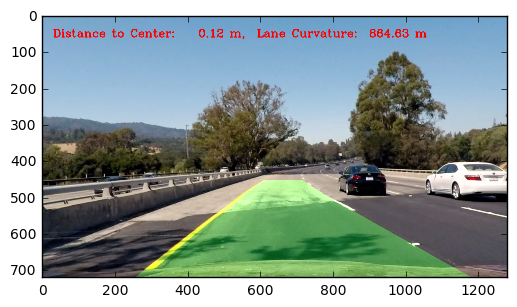

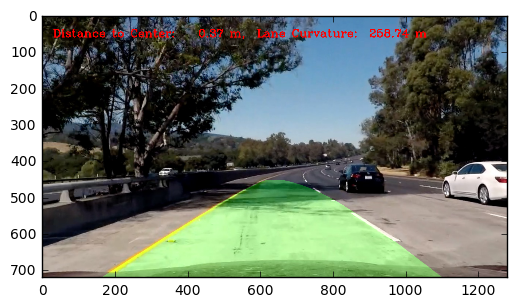

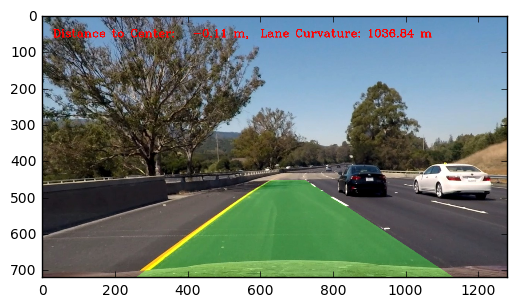

In [291]:
os.listdir("test_images/")

# inicalize lanes
left_lane = Line() 
right_lane = Line()
for ima in os.listdir("test_images/"):
    img = mpimg.imread('test_images/'+ima )
    plt.figure()
    plt.imshow(process_image(img))



run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [284]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [285]:
white_output = 'lane_finding.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video lane_finding.mp4
[MoviePy] Writing video lane_finding.mp4


100%|█████████▉| 1260/1261 [05:46<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_finding.mp4 

CPU times: user 5min 27s, sys: 1min 12s, total: 6min 39s
Wall time: 5min 47s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [286]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Optional Challenge (Still Working on)

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [287]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|█████████▉| 1199/1200 [05:21<00:00,  3.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5min 9s, sys: 1min 7s, total: 6min 17s
Wall time: 5min 22s


In [288]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))